In [ ]:
import requests
import pandas as pd
import numpy as np
import gzip
import shutil
from datetime import date, timedelta, datetime
from scipy.stats import kstest, expon
import matplotlib.pyplot as plt

In [ ]:
def read_data():
  start = date(2022, 1, 1)
  end = date(2022, 12, 31)
  delta = timedelta(days=1)
  data = []
  while(start <= end):
    url = 'https://gz.blockchair.com/bitcoin/blocks/blockchair_bitcoin_blocks_' + start.strftime('%Y%m%d') + '.tsv.gz'
    req = requests.get(url, allow_redirects=True)
    open('file.gz', 'wb').write(req.content)
    data.append(pd.read_csv('file.gz', sep='\t', compression='gzip'))
    start += delta
  return pd.concat(data)

In [ ]:
df = read_data()

In [ ]:
df.head()

,id,hash,time,median_time,size,stripped_size,weight,version,version_hex,version_bits,...,fee_per_kb,fee_per_kb_usd,fee_per_kwu,fee_per_kwu_usd,cdd_total,generation,generation_usd,reward,reward_usd,guessed_miner
0,716599,0000000000000000000288bb2cdbd907a32fdff4b8d9db...,2022-01-01 00:04:14,2021-12-31 23:30:21,1426751,848043,3970880,545259520,20800000,100000100000000000000000000000,...,8892.15,4.1159,3195.31,1.4789,17432.616913,625000000,289300.0,637683092,295170.7500,Binance
1,716600,00000000000000000001fa03c2ad182a401c03c42f3e52...,2022-01-01 00:14:14,2021-12-31 23:31:24,1496543,833921,3998306,547356676,20a00004,100000101000000000000000000100,...,10996.80,5.0903,4116.62,1.9057,13331.088835,625000000,289300.0,641451750,296915.1875,F2Pool
2,716601,000000000000000000020f5e0c167fa9d817a16cb6c334...,2022-01-01 00:20:25,2021-12-31 23:49:55,868849,477523,2301418,549453824,20c00000,100000110000000000000000000000,...,8730.22,4.0409,3296.61,1.5261,7520.012028,625000000,289300.0,632581371,292809.2500,ViaBTC
3,716602,00000000000000000003e9f054f5c6f3f71e11b790fe1c...,2022-01-01 00:23:25,2021-12-31 23:53:28,207301,114438,550615,632782852,25b78004,100101101101111000000000000100,...,12331.10,5.7078,4645.92,2.1505,7563.960865,625000000,289300.0,627551570,290481.0625,SlushPool
4,716603,000000000000000000072ba79db2b57c4efa08f11f1d8f...,2022-01-01 00:28:47,2021-12-31 23:59:06,419910,234243,1122639,545259520,20800000,100000100000000000000000000000,...,11910.80,5.5134,4456.77,2.0631,3233.225948,625000000,289300.0,629996691,291612.8750,ViaBTC


In [ ]:
def get_durations(blocks):
  durations = []
  last_time = None
  for _, block in blocks.iterrows():
    current_time = datetime.strptime(block['time'], '%Y-%m-%d %H:%M:%S')
    if last_time == None:
      last_time = current_time
    else:
      durations.append((current_time - last_time).total_seconds())
      last_time = current_time
  return np.divide(durations, 60)

In [ ]:
def test(blocks):
  durations = get_durations(blocks)
  bins = np.linspace(0, np.max(durations), 50)
  plt.hist(durations, bins=bins)
  plt.show()
  mean = np.mean(durations)
  var = np.var(durations)
  print('mean:', mean)
  print('variance:', var)

  alpha = 0.05
  null_hypothesis = lambda x: expon.cdf(x, scale=mean)
  test_statistic, p_value = kstest(durations, null_hypothesis)
  if p_value >= alpha:
    print('Accepted')
  else:
    print('Rejected')

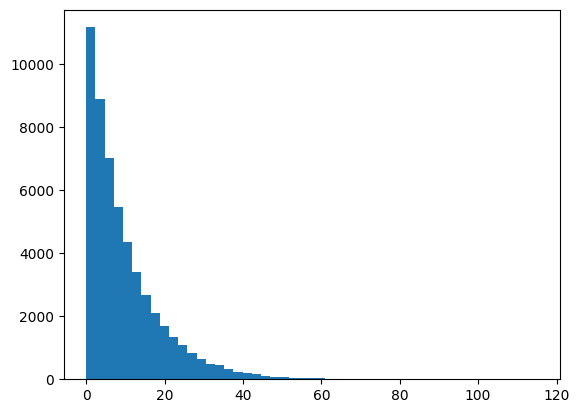

mean: 9.881480123589098
variance: 98.29269688085358
Accepted


In [ ]:
test(df)

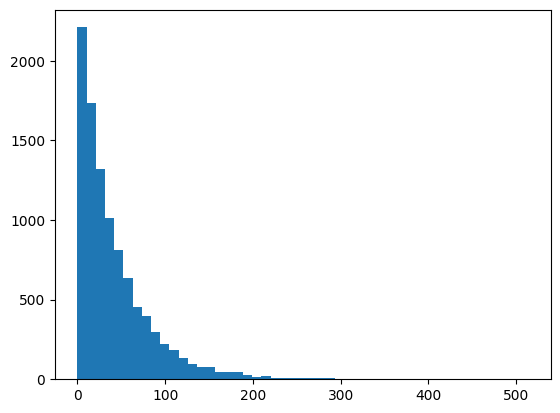

mean: 42.13254961318533
variance: 1881.7786886446681
Accepted


In [ ]:
test(df[df['guessed_miner'] == 'Foundry USA Pool'])

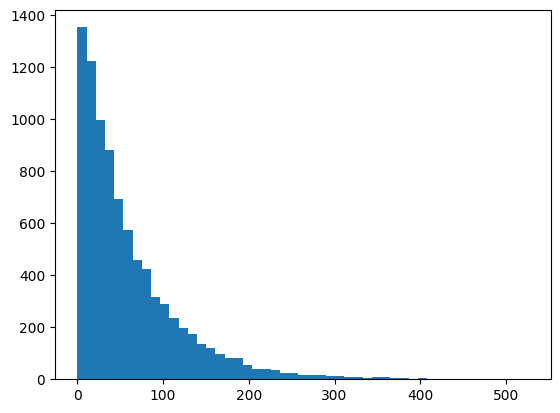

mean: 60.53538978494624
variance: 3683.239711304801
Accepted


In [ ]:
test(df[df['guessed_miner'] == 'AntPool'])